# SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la carga de los módulos necesarios:

In [1]:
import pandas as pd
import numpy as np
# ! pip install lightgbm
import lightgbm as lgb
import random
random.seed(7)

Cargamos con **pandas** lentamente el dataset. Sólo vamos a trabajar con el primer conjunto de datos que es el más pequeño. Con un poco más de paciencia podrá usar los conjuntos más pesados. 

In [2]:
df_train = pd.read_csv("../../../datasets/competencia2_2022.csv.gz")

Xtrain = df_train[df_train["foto_mes"] < 202104]
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)

/home/santiago/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3135: DtypeWarning: Columns (154) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Separamos también todos los casos de **BAJAS+1** y **BAJAS+2**

In [3]:
Xbajas = df_train.query("foto_mes == 202101 and clase_ternaria != 'CONTINUA'")

In [5]:
Xtrain.groupby(["foto_mes","clase_ternaria"]).count()

numero_de_cliente  active_quarter  cliente_vip  \
foto_mes clase_ternaria                                                   
202101   BAJA+1                        664             664          664   
         BAJA+2                        850             850          850   
         CONTINUA                   159828          159828       159828   
202102   BAJA+1                        854             854          854   
         BAJA+2                       1018            1018         1018   
         CONTINUA                   160047          160047       160047   
202103   BAJA+1                       1019            1019         1019   
         BAJA+2                        960             960          960   
         CONTINUA                   160921          160921       160921   

                         internet  cliente_edad  cliente_antiguedad  \
foto_mes clase_ternaria                                               
202101   BAJA+1               664           664                 664   
         BAJA+2               850           850                 850   
         CONTINUA          159828        159828              159828   
202102   BAJA+1               854           854                 854   
         BAJA+2              1018          1018                1018   
         CONTINUA          160047        160047              160047   
202103   BAJA+1              1019          1019                1019   
         BAJA+2               960           960                 960   
         CONTINUA          160921        160921              160921   

                         mrentabilidad  mrentabilidad_annual  mcomisiones  \
foto_mes clase_ternaria                                                     
202101   BAJA+1                    664                   664          664   
         BAJA+2                    850                   850          850   
         CONTINUA               159828                159828       159828   
202102   BAJA+1                    854                   854          854   
         BAJA+2                   1018                  1018         1018   
         CONTINUA               160047                160047       160047   
202103   BAJA+1                   1019                  1019         1019   
         BAJA+2                    960                   960          960   
         CONTINUA               160921                160921       160921   

                         mactivos_margen  ...  Visa_madelantodolares  \
foto_mes clase_ternaria                   ...                          
202101   BAJA+1                      664  ...                    311   
         BAJA+2                      850  ...                    377   
         CONTINUA                 159828  ...                 138324   
202102   BAJA+1                      854  ...                    366   
         BAJA+2                     1018  ...                    521   
         CONTINUA                 160047  ...                 139197   
202103   BAJA+1                     1019  ...                    524   
         BAJA+2                      960  ...                    522   
         CONTINUA                 160921  ...                 139929   

                         Visa_fultimo_cierre  Visa_mpagado  Visa_mpagospesos  \
foto_mes clase_ternaria                                                        
202101   BAJA+1                          537           537               311   
         BAJA+2                          621           621               377   
         CONTINUA                     152321        152360            138324   
202102   BAJA+1                          615           615               366   
         BAJA+2                          793           793               521   
         CONTINUA                     152665        152681            139197   
202103   BAJA+1                          797           797               524   
         BAJA+2                          751           7

Y nos deshacemos del target y limpiamos un poco la memoria.

In [6]:
Xtrain = Xtrain.drop("clase_ternaria", axis=1)
Xbajas = Xbajas.drop("clase_ternaria", axis=1)

del(df_train)

Hacemos un modelo **LGBM**

In [7]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(Xtrain, ytrain)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'learning_rate': 0.05,
    'verbose': 2,
    'max_bin': 15,
    'min_data_in_leaf': 4000,
    'verbose': 0,
    'random_state':7
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100)


lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


,Features,Importances
8,mrentabilidad_annual,184
10,mactivos_margen,110
33,mprestamos_personales,101
72,mcomisiones_mantenimiento,96
22,mcuentas_saldo,93
...,...,...
76,cforex_buy,0
75,cforex,0
70,mtarjeta_master_descuentos,0
69,ctarjeta_master_descuentos,0


Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

In [8]:
#! pip install shap
import shap

In [9]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(Xbajas)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Consolidamos los valores de **SHAP** para cada variable y para cada **BAJA+\***

In [10]:
shap_bajas = pd.DataFrame(shap_values[0], columns = Xbajas.columns)
shap_bajas

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo
0,-0.019637,0.044174,0.0,0.0,-0.004919,0.020443,0.009873,-0.034149,0.211458,-0.009837,...,0.0,0.002527,-0.024459,-0.022866,-0.000136,-0.026699,0.0,0.019884,0.0,-0.090427
1,-0.008569,0.084822,0.0,0.0,-0.010236,0.021979,-0.000090,0.010422,-0.135430,-0.004537,...,0.0,-0.002302,0.001369,-0.012956,-0.001003,-0.018384,0.0,-0.047349,0.0,-0.062171
2,-0.016967,0.054335,0.0,0.0,-0.001732,-0.141537,0.001850,0.003780,0.025109,-0.001958,...,0.0,-0.000840,-0.006366,0.021607,-0.000187,-0.011685,0.0,0.024611,0.0,0.048192
3,-0.013793,0.024037,0.0,0.0,-0.007874,-0.080143,-0.000741,-0.008421,0.010532,-0.007211,...,0.0,0.000058,0.002871,0.001967,-0.000172,-0.072663,0.0,0.027299,0.0,-0.075694
4,-0.000339,0.046054,0.0,0.0,-0.010156,-0.107481,0.002993,-0.034351,0.223561,-0.009630,...,0.0,-0.000194,-0.039338,-0.030395,-0.000136,-0.057013,0.0,0.024831,0.0,-0.152875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509,0.100793,0.056527,0.0,0.0,-0.003332,0.018772,-0.007185,0.005340,-0.074556,-0.000674,...,0.0,0.000210,0.002295,-0.014714,-0.000062,0.075200,0.0,0.062031,0.0,0.153920
1510,0.033949,0.028758,0.0,0.0,-0.006937,0.024844,0.020535,0.011466,-0.090984,0.000624,...,0.0,0.000111,0.003950,-0.011641,-0.008583,0.101589,0.0,0.000588,0.0,-0.122508
1511,0.021864,0.040414,0.0,0.0,-0.009105,0.026652,0.020135,0.025676,-0.115263,0.000258,...,0.0,0.000128,0.004086,-0.009113,-0.008583,0.100018,0.0,0.004177,0.0,-0.160533
1512,0.026929,0.026278,0.0,0.0,-0.006129,-0.089251,0.040322,-0.009211,-0.130583,-0.009858,...,0.0,0.000930,0.002972,-0.010948,-0.008476,0.092160,0.0,0.001367,0.0,-0.104424


Y consolidamos sus importancias

In [11]:
shap_importancias = shap_bajas.mean().abs().sort_values(ascending=False)
shap_importancias

ctrx_quarter                    0.928707
cpayroll_trx                    0.413580
mpayroll                        0.366660
mtarjeta_visa_consumo           0.241232
mprestamos_personales           0.179510
                                  ...   
mtarjeta_visa_descuentos        0.000000
Master_madelantodolares         0.000000
mcheques_emitidos_rechazados    0.000000
minversion1_pesos               0.000000
mforex_buy                      0.000000
Length: 154, dtype: float64

La librería nos da útiles herramientas para vizualizar la info anterior

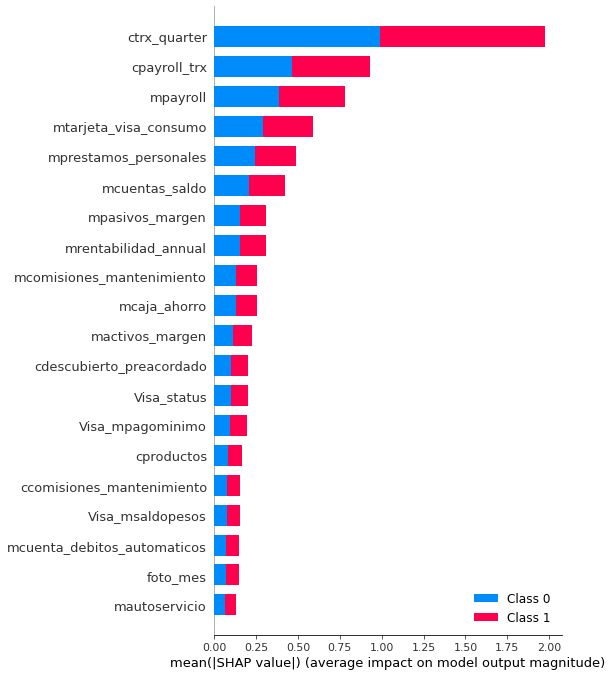

In [12]:
shap.summary_plot(shap_values, Xbajas)


Y ahora debemos empezar a jugar para entender como estan asociadas las variables a los **shap values**

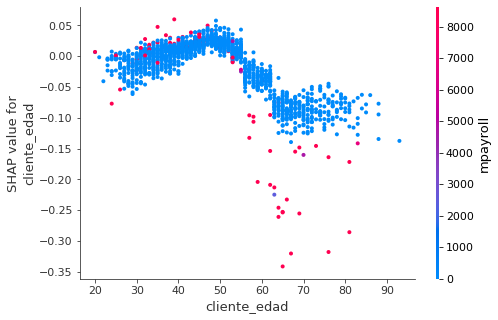

In [13]:
shap.dependence_plot("cliente_edad", shap_values[0], Xbajas)

¿Se podrá hacer una clusterización sobre los valores de shap? 

Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Como la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento.

In [14]:
from umap import UMAP
import matplotlib.pyplot as plt


2022-11-01 11:12:45.684523: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/santiago/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-11-01 11:12:45.684541: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


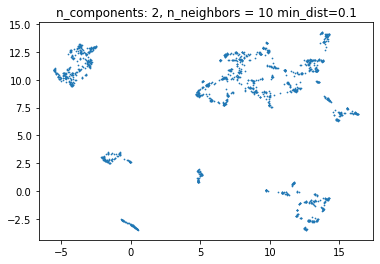

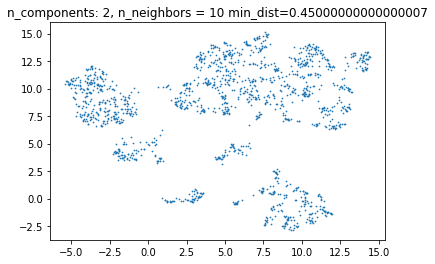

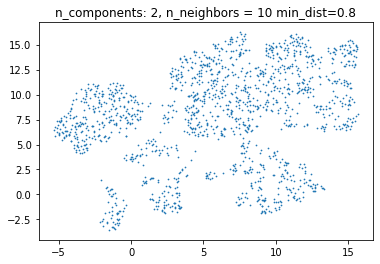

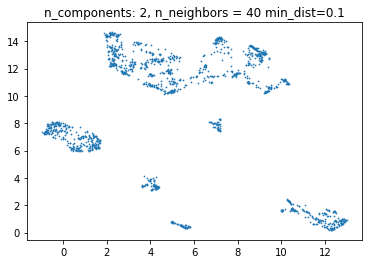

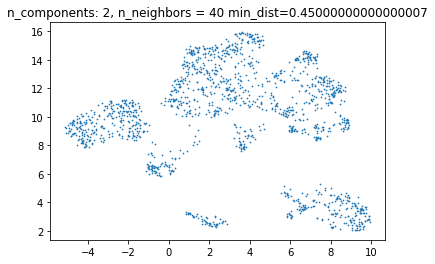

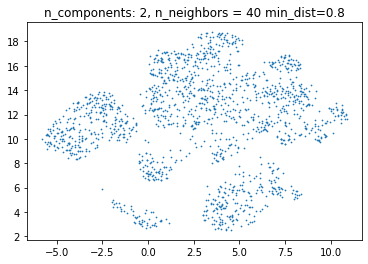

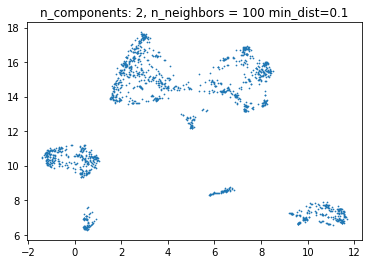

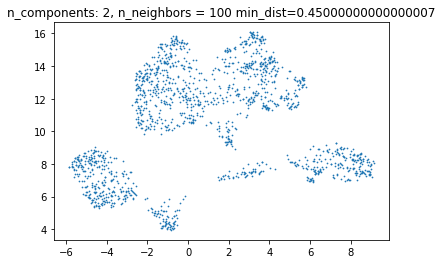

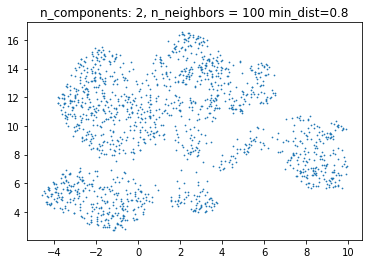

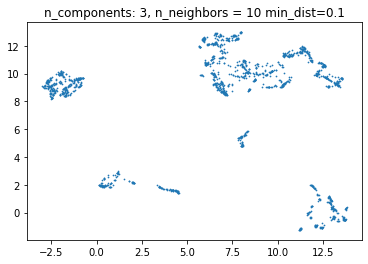

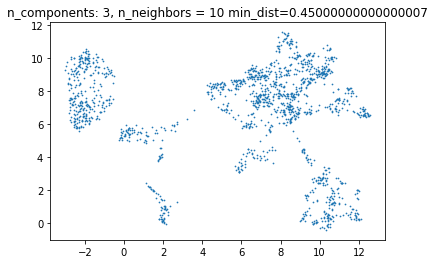

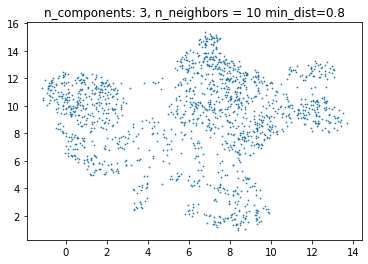

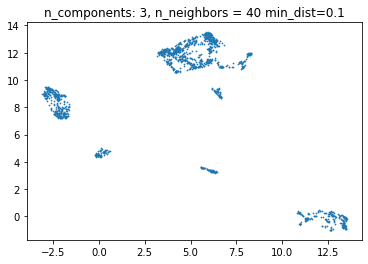

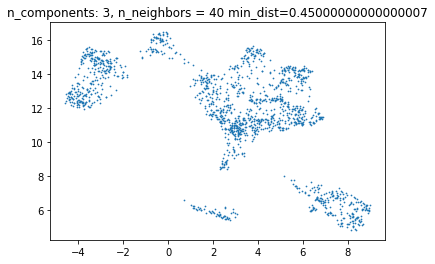

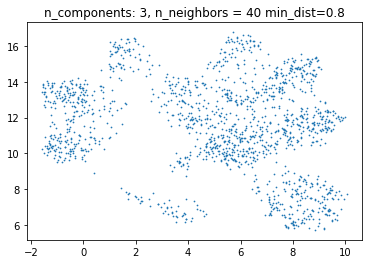

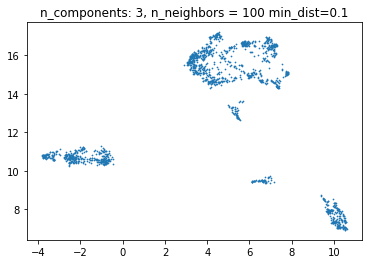

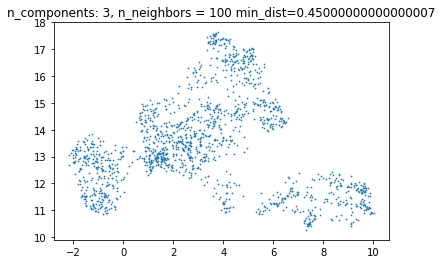

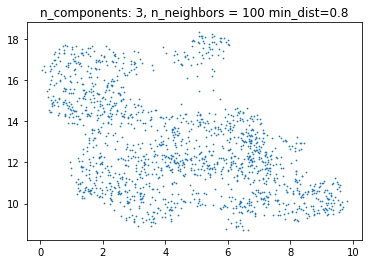

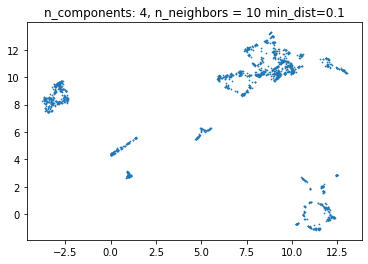

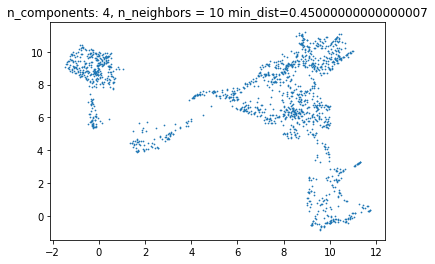

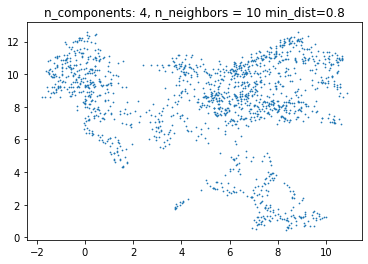

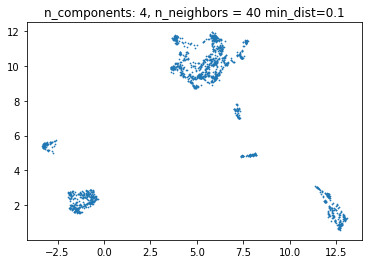

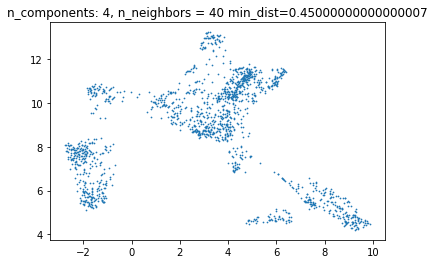

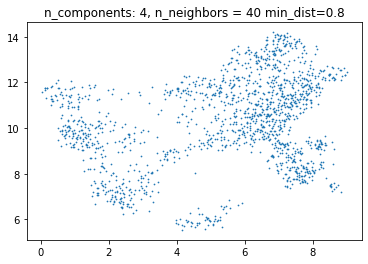

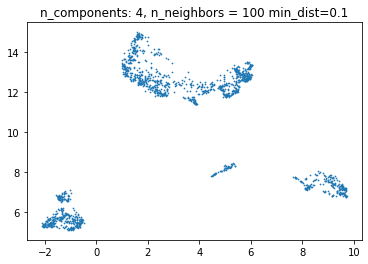

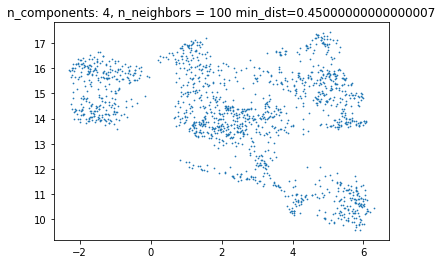

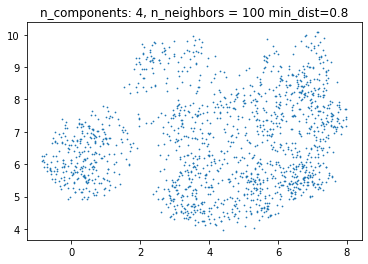

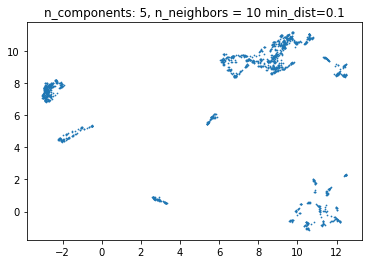

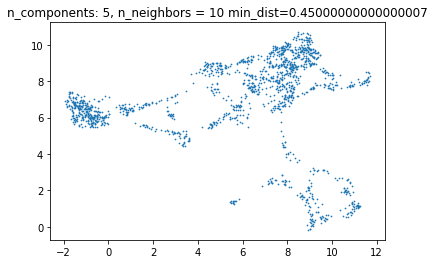

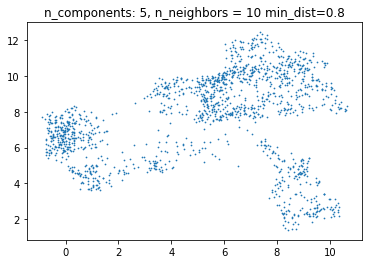

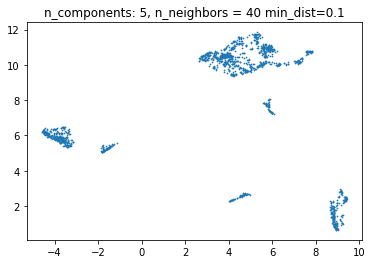

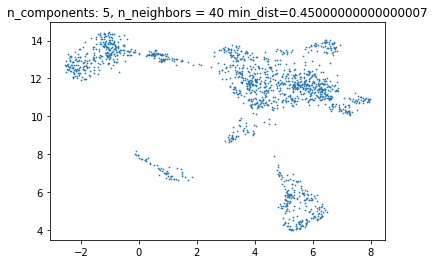

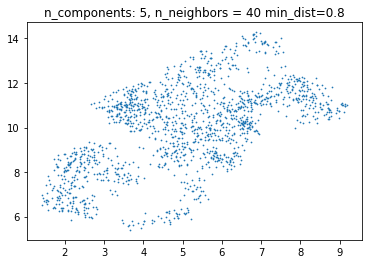

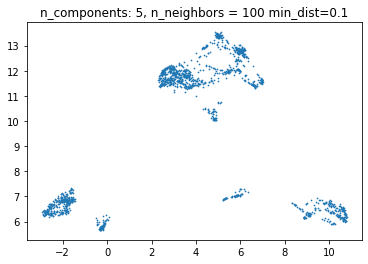

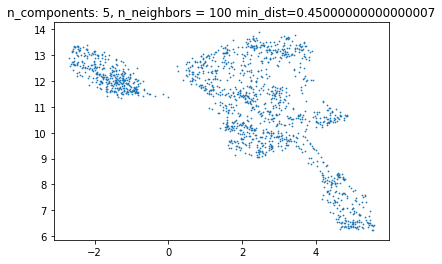

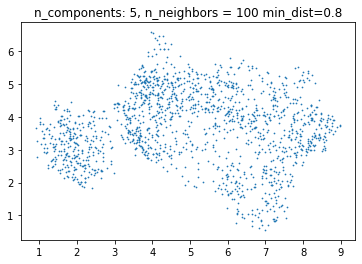

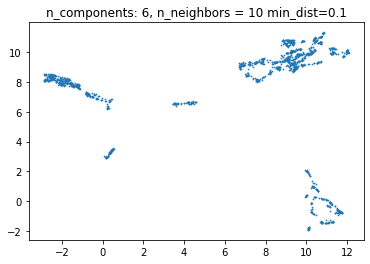

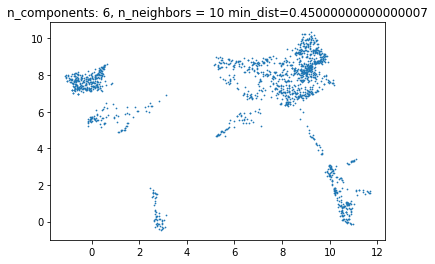

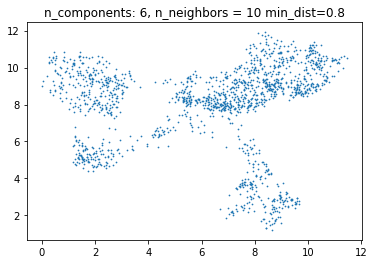

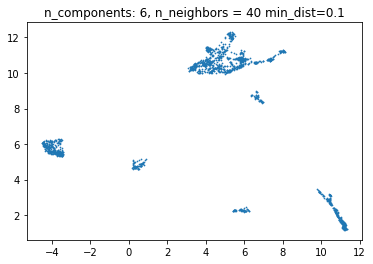

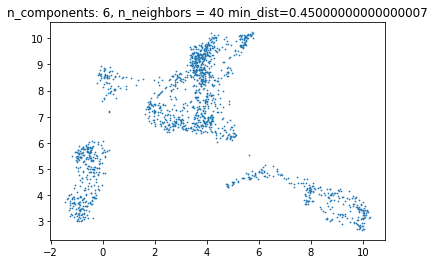

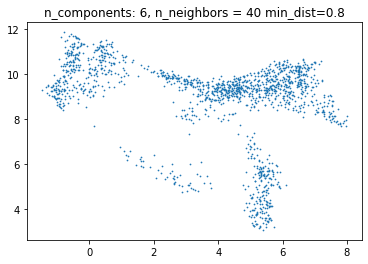

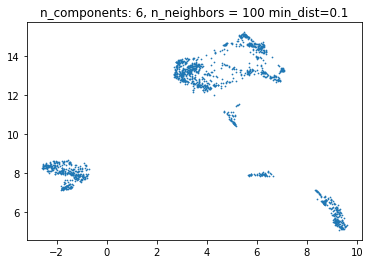

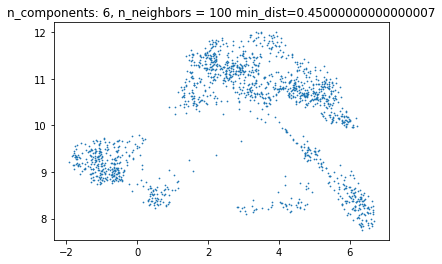

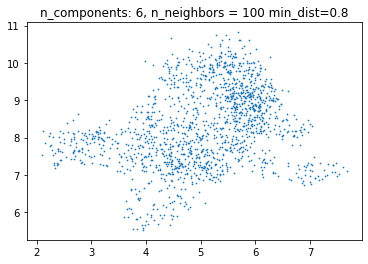

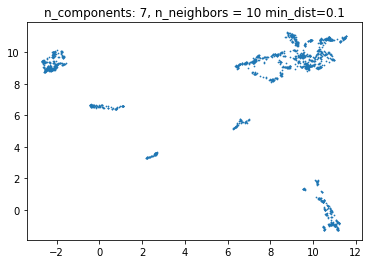

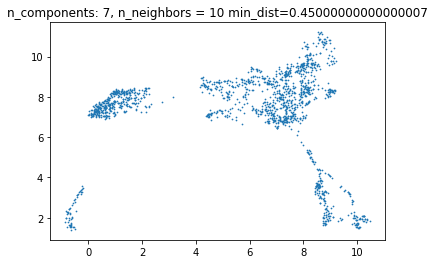

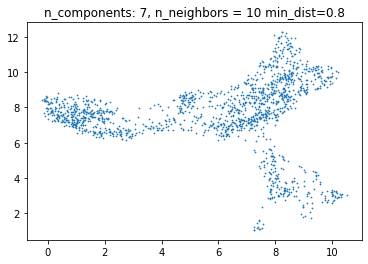

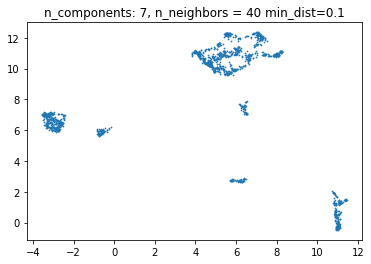

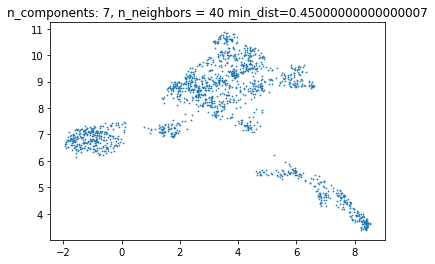

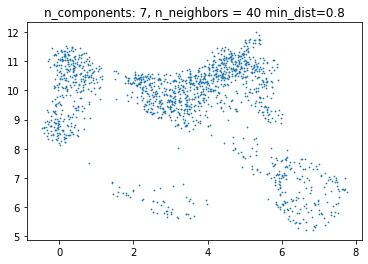

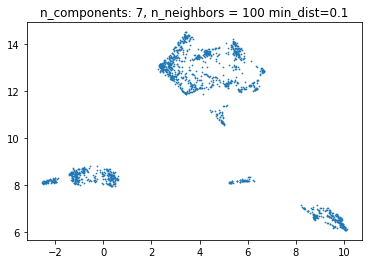

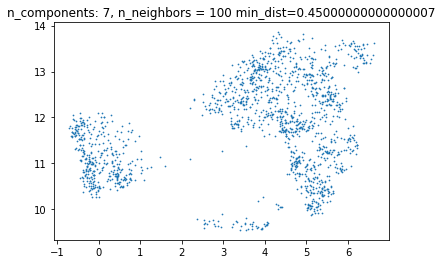

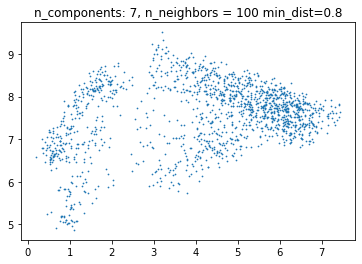

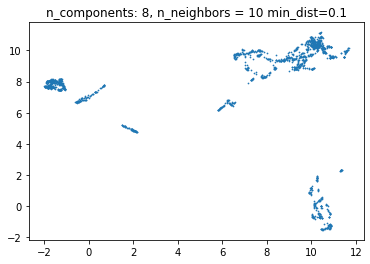

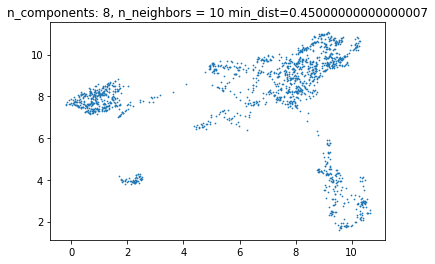

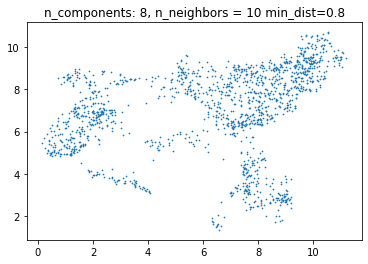

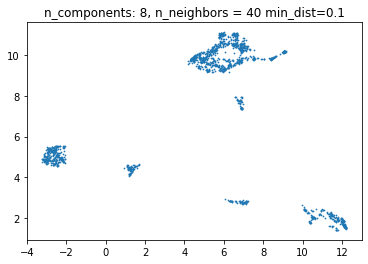

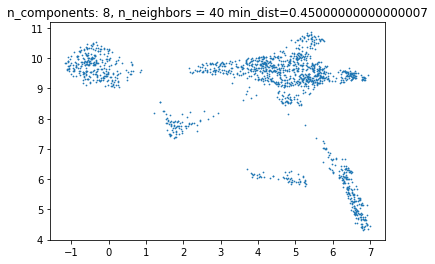

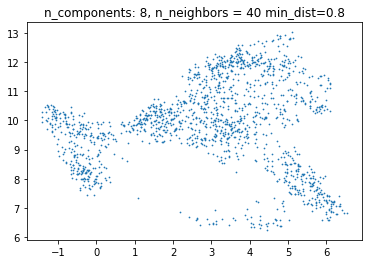

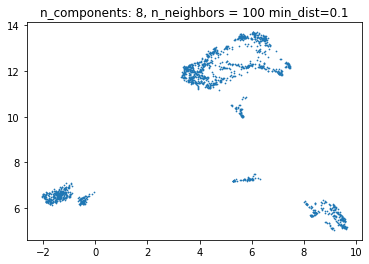

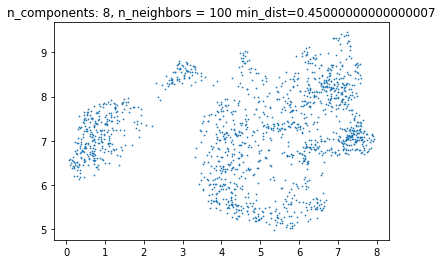

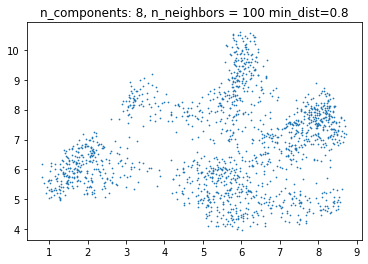

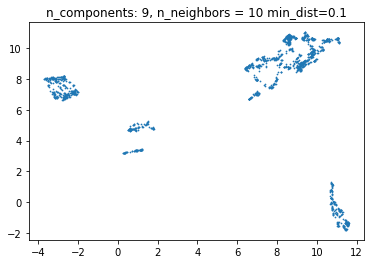

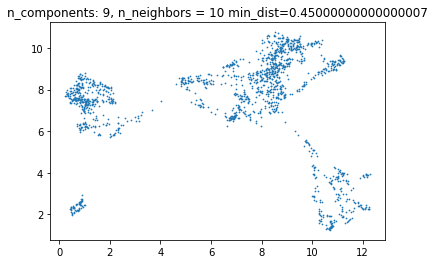

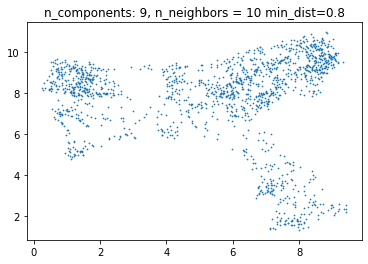

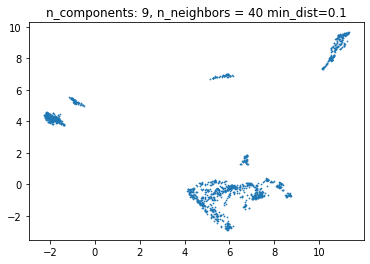

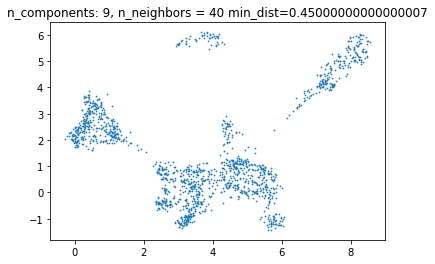

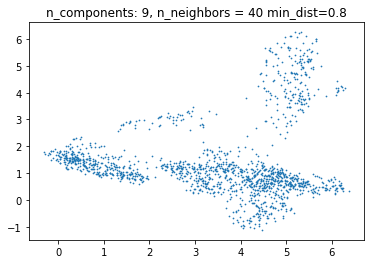

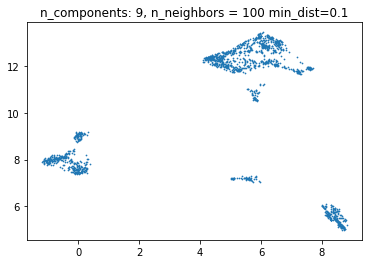

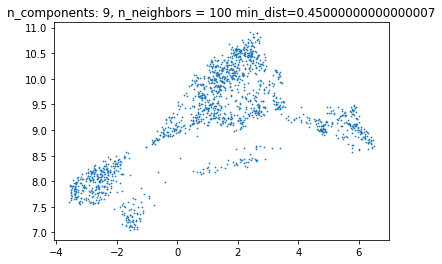

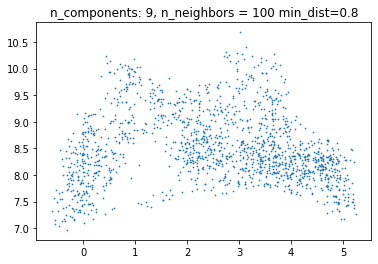

In [15]:
for n_comp in range(2,10):
    for n_nei in [10,40,100]:
        for min_dist in np.linspace(0.1,0.8,3):
            embedding_2d = UMAP(n_components=n_comp,
                                n_neighbors=n_nei, random_state=7,
                               min_dist=min_dist).fit_transform(shap_values[0])
            plt.figure()
            plt.scatter(embedding_2d[:,0], embedding_2d[:,1], s = .5)
            plt.title(f"n_components: {n_comp}, n_neighbors = {n_nei} min_dist={min_dist}")

Text(0.5, 1.0, 'n_components: 6, n_neighbors = 40')

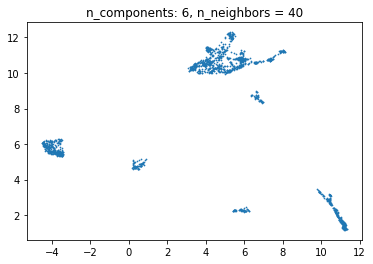

In [16]:
# Elijo una combinación que me haya gustado.
n_comp, n_nei, min_dist = 6, 40, 0.1

embedding_2d = UMAP(n_components=n_comp, n_neighbors=n_nei, random_state=7).fit_transform(shap_values[0])
plt.figure()
plt.scatter(embedding_2d[:,0], embedding_2d[:,1], s = 0.5)
plt.title(f"n_components: {n_comp}, n_neighbors = {n_nei}")

In [17]:
#! pip install hdbscan
import hdbscan

In [18]:
labels = hdbscan.HDBSCAN(
    min_samples=20,
    min_cluster_size=20,
).fit_predict(embedding_2d)

In [22]:
# labels[[i in [-1,4,6,7,8,9,10,11,12,13] for i in labels]] = 4

# # Ojo, acá estoy dejando muestras sin clasificar.
clustered = (labels >= 0)


In [20]:
labels += 1

## Su momento de brillar: Qué se puede hacer desde este punto para tratar de interpretar los distintos segmentos para la presentación de Miranda.

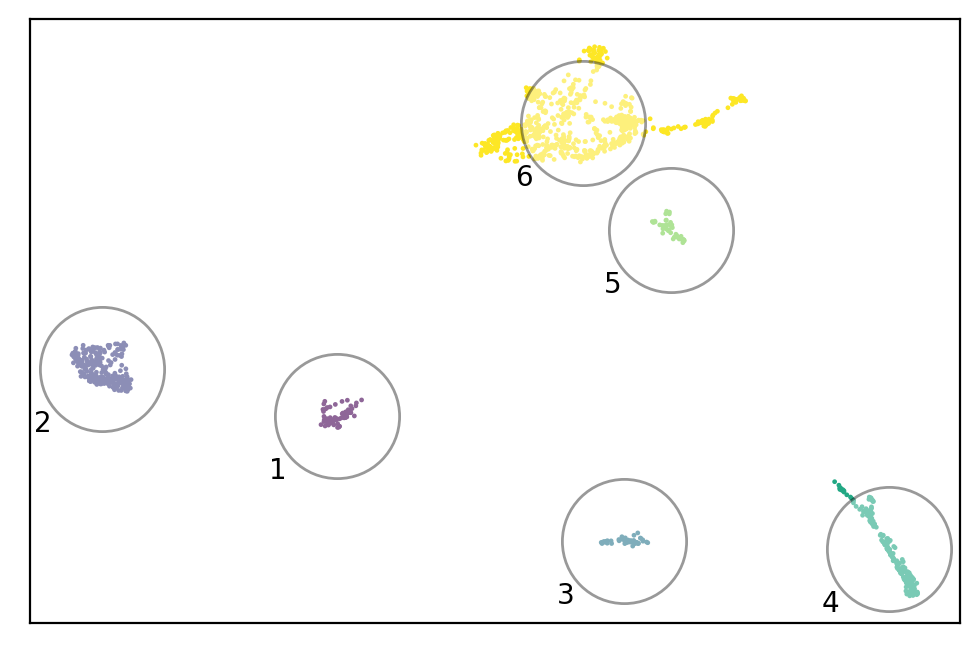

In [46]:
plt.figure(dpi = 200)
plt.scatter(embedding_2d[clustered, 0], embedding_2d[clustered, 1], c=labels[clustered], s=0.5, cmap='viridis');
# Si hay muestras sin clasificar, van en negro.
plt.scatter(embedding_2d[~clustered, 0], embedding_2d[~clustered, 1], c="black", s=.1)

shapx = embedding_2d[:, 0]
shapy = embedding_2d[:, 1]
label = labels
# Así vemos la media de cada grupo en los dos ejes.
shap_centroids = pd.DataFrame({"shapx":shapx,
             "shapy":shapy,
             "label":label }).groupby("label").mean()

for i,row in shap_centroids.iterrows():
    plt.scatter(row.shapx, row.shapy, s = 2000, facecolors='white', edgecolors='k', alpha = .4)
    plt.text(row.shapx-1.1, row.shapy-1.1, s = str(i), va = "center", ha = "center", fontsize = 10)
    
plt.xticks([])
plt.yticks([])

plt.savefig('clustered.png', transparent=True)

In [47]:
Xbajas["cluster"] = labels

In [48]:
top_cols = list(lgbm_importancia.Features.head(10))

47.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
52.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


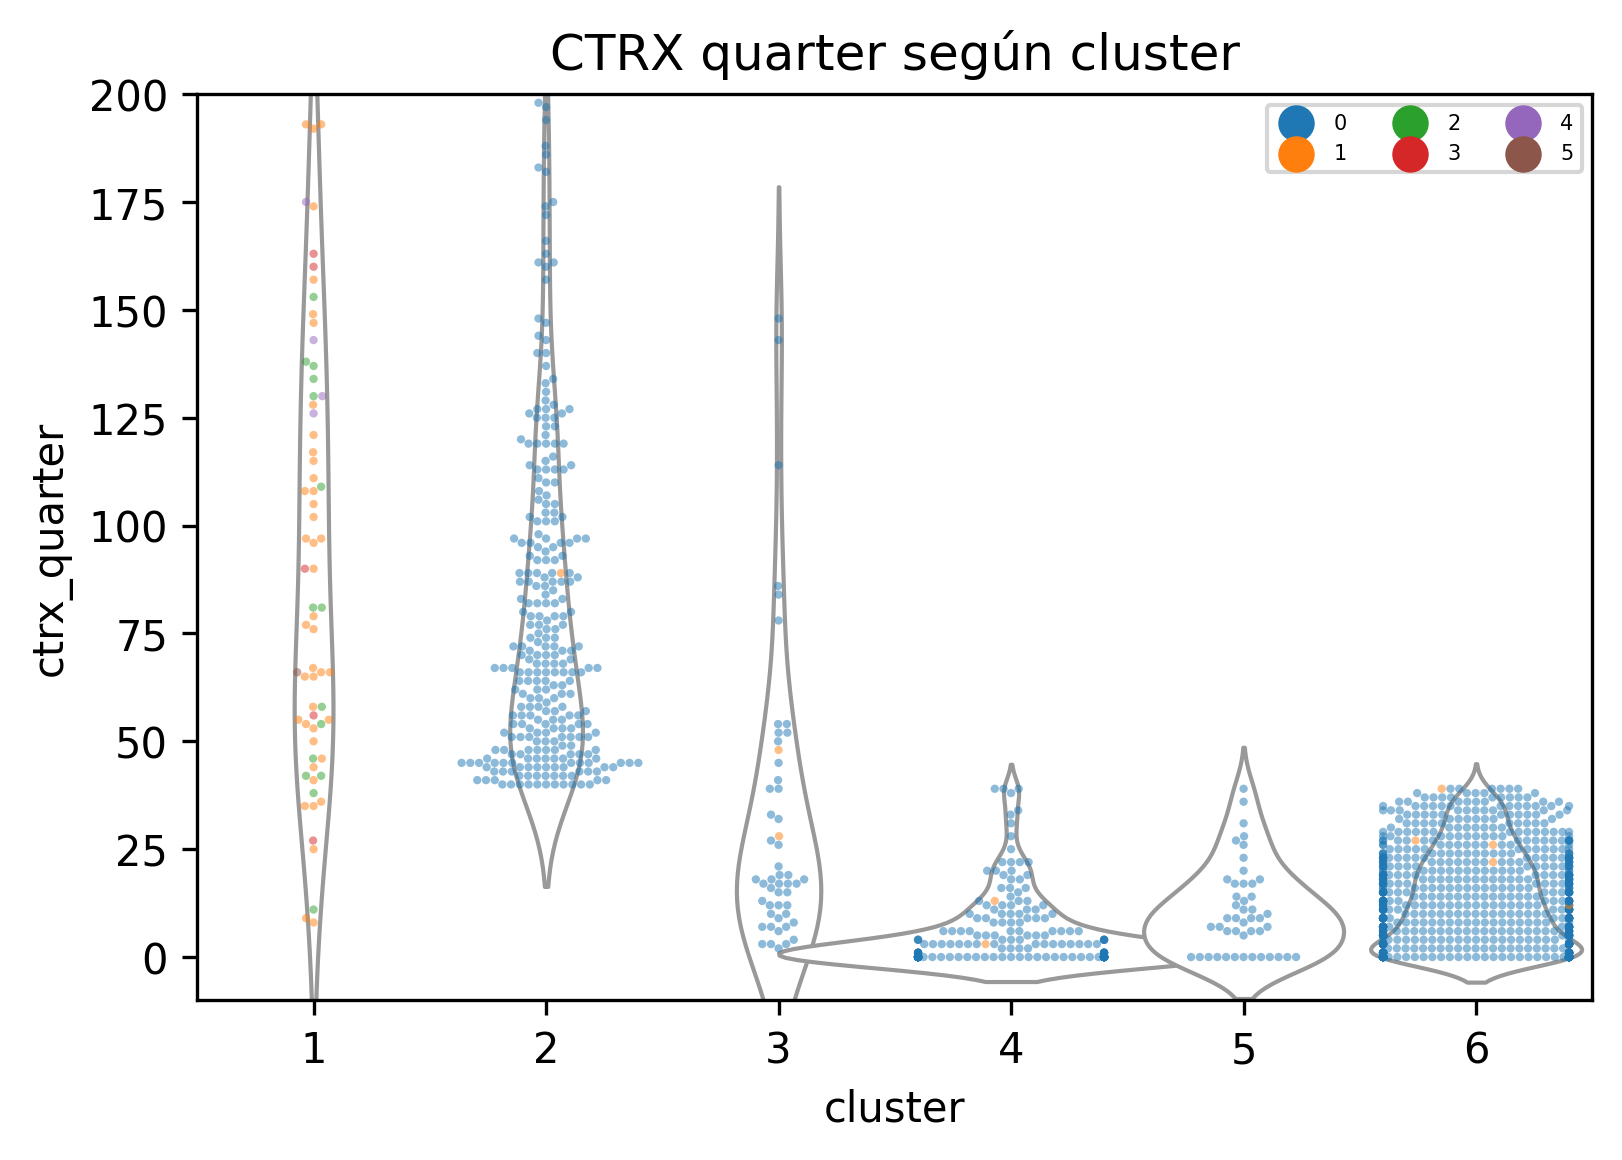

In [49]:
import seaborn as sns
plt.figure(dpi = 300)

sns.swarmplot(y="ctrx_quarter", 
                x="cluster", 
                data=Xbajas[Xbajas.ctrx_quarter < 200], 
                   hue="cpayroll_trx", palette = "tab10", s = 2, alpha = 0.5)

sns.violinplot(data = Xbajas[Xbajas.ctrx_quarter < 200],
            y = "ctrx_quarter", 
            x = "cluster", 
            saturation = 1,
            color = "white",
           linewidth = 1, width=2, inner= None)

plt.ylim(-10,200)
plt.title("CTRX quarter según cluster")
plt.legend(ncol = 3, fontsize = 5);

In [50]:
def coloured_table(columna, cols = ["25%","50%","75%"], verbose = True, fillna = True):
    if fillna: 
        Xb = Xbajas.fillna(0);  Xt= Xtrain.fillna(0)
    else:
        Xb = Xbajas
        Xt = Xtrain
    bajas = Xb[["cluster",columna]].groupby("cluster").describe()
    conts = Xt[ytrain == 0][[columna]].describe().transpose()
    bajas.index = [f"BAJA_{i}" for i in bajas.index]
    conts.index = ["CONTINUA"]

    bajas.columns = conts.columns
    if verbose: print(columna)
    return bajas.append(conts)[cols].style\
    .background_gradient(cmap='ocean', axis=None)\
    .highlight_null(null_color='#f1f1f1')\
    .set_precision(2)

In [51]:
coloured_table("ctrx_quarter", ["count"], verbose = False)

,count
BAJA_1,75.00
BAJA_2,291.00
BAJA_3,51.00
BAJA_4,213.00
BAJA_5,46.00
BAJA_6,838.00
CONTINUA,480796.00


In [78]:
75 / len(Xbajas) * 100

4.953764861294584

In [52]:
coloured_table("mcuentas_saldo")

mcuentas_saldo


,25%,50%,75%
BAJA_1,2997.75,26532.26,94889.01
BAJA_2,-910.42,4649.23,40690.50
BAJA_3,-3022.02,-75.33,1078.95
BAJA_4,-11998.01,-2343.31,14.81
BAJA_5,-9167.37,-2511.35,804.49
BAJA_6,-5062.52,-963.25,649.63
CONTINUA,959.45,35371.90,139751.95


Se aprecia claramente como hay marcadas diferencias en los clusters. Si bien el promedio de mcuentas_saldo (**saldo total de todas las cuentas del cliente en pesos**) es en todos los baja inferior, hay varios clusters de usuarios baja con saldo elevado en cuenta: cluster 2, 5 y 6. Por el otro lado, están los clusters 1,3 y 4 donde están representados usuarios con bajo saldo en cuenta, incluso con la mayoría de ellos en negativo.

In [53]:
coloured_table("ctrx_quarter")

ctrx_quarter


,25%,50%,75%
BAJA_1,54.50,96.00,140.50
BAJA_2,50.00,70.00,102.00
BAJA_3,11.00,18.00,43.00
BAJA_4,0.00,1.00,6.00
BAJA_5,0.00,9.00,17.00
BAJA_6,3.00,11.00,22.00
CONTINUA,60.00,106.00,159.00


La variable ctrx_quarter representa la **cantidad de movimientos en las cuentas bancarias de los últimos tres meses**. Vemos que nuevamente, los usuarios de los clusters 2 y 6 tienen el comportamiento más similar a los continua, mientras que los de los clusters 1,3,4 tienen valores bajos de movimientos. El cluster 5 tenía un comportamiento intermedio en la variable anterior y repite en esta.

In [54]:
coloured_table("Visa_mconsumototal")

Visa_mconsumototal


,25%,50%,75%
BAJA_1,0.00,1173.53,10282.61
BAJA_2,0.00,3002.88,12263.63
BAJA_3,0.00,0.00,2328.78
BAJA_4,0.00,0.00,0.00
BAJA_5,0.00,0.00,0.00
BAJA_6,0.00,0.00,466.82
CONTINUA,510.20,6897.35,22295.53


Se complica separar a los grupos, voy a entrenar otro modelo para predecir cluster

In [55]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(Xbajas.drop(columns = "cluster"),  Xbajas.cluster -1)

# specify your configurations as a dict
params = {
    'objective': 'multiclass',
    'learning_rate': 0.05,
    'verbose': 2,
    'max_bin': 15,
    'min_data_in_leaf': 50,
    'verbose': 0,
    "num_class":6
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100)





[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [56]:
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia.head(20)

,Features,Importances
107,ctrx_quarter,2316
18,mcaja_ahorro,1231
33,mprestamos_personales,875
21,cdescubierto_preacordado,722
11,mpasivos_margen,563
149,Visa_fechaalta,439
81,mtransferencias_recibidas,426
127,Master_fechaalta,425
8,mrentabilidad_annual,424
12,cproductos,379


In [57]:
coloured_table("mpasivos_margen")

mpasivos_margen


,25%,50%,75%
BAJA_1,256.80,601.36,1474.50
BAJA_2,91.80,292.64,707.16
BAJA_3,23.71,136.88,463.25
BAJA_4,0.00,2.10,30.68
BAJA_5,1.66,14.37,89.15
BAJA_6,0.00,9.14,73.95
CONTINUA,241.51,670.32,1566.09


In [59]:
coloured_table("mcuenta_corriente")

mcuenta_corriente


,25%,50%,75%
BAJA_1,-379.35,0.00,0.00
BAJA_2,-894.09,-29.60,0.00
BAJA_3,-2928.11,-449.10,0.00
BAJA_4,-12101.46,-1468.84,0.00
BAJA_5,-6935.80,-1972.27,-25.70
BAJA_6,-4090.46,-506.22,0.00
CONTINUA,-781.36,0.00,0.00


In [60]:
coloured_table("Visa_mpagominimo", fillna=False)

Visa_mpagominimo


,25%,50%,75%
BAJA_1,11.73,1032.24,3542.46
BAJA_2,149.56,1049.84,3744.80
BAJA_3,0.00,0.00,598.23
BAJA_4,0.00,0.00,43.99
BAJA_5,0.00,0.00,11.73
BAJA_6,0.00,0.00,199.41
CONTINUA,539.58,2205.24,5747.70


El cluster 1 es particular: no tiene acuerdo de descubierto.

In [61]:
coloured_table("cdescubierto_preacordado", fillna=False)

cdescubierto_preacordado


,25%,50%,75%
BAJA_1,1.00,1.00,1.00
BAJA_2,1.00,1.00,1.00
BAJA_3,0.50,1.00,1.00
BAJA_4,0.00,0.00,0.00
BAJA_5,0.00,1.00,1.00
BAJA_6,1.00,1.00,1.00
CONTINUA,1.00,1.00,1.00


In [38]:
Xbajas.groupby("cluster").quantile(.25)[["cdescubierto_preacordado"]]

,cdescubierto_preacordado
cluster,
1,1.0
2,1.0
3,0.5
4,0.0
5,0.0
6,1.0


In [62]:
coloured_table("cliente_antiguedad", fillna=False)

cliente_antiguedad


,25%,50%,75%
BAJA_1,29.50,81.00,173.00
BAJA_2,66.00,121.00,185.00
BAJA_3,46.00,128.00,187.00
BAJA_4,45.00,71.00,149.00
BAJA_5,37.25,43.00,83.00
BAJA_6,37.00,77.00,158.00
CONTINUA,62.00,126.00,188.00


<AxesSubplot:xlabel='cluster', ylabel='cliente_antiguedad'>

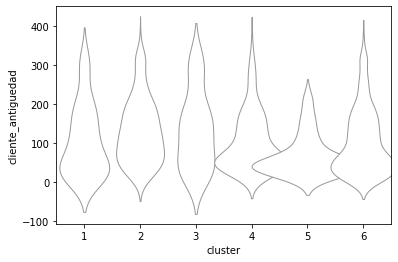

In [63]:
sns.violinplot(data = Xbajas,
            y = "cliente_antiguedad", 
            x = "cluster", 
            saturation = 1,
            color = "white",
           linewidth = 1, width=2, inner= None)

In [ ]:
83.00

In [72]:
coloured_table("cpayroll_trx", fillna=True)

cpayroll_trx


,25%,50%,75%
BAJA_1,1.00,1.00,2.00
BAJA_2,0.00,0.00,0.00
BAJA_3,0.00,0.00,0.00
BAJA_4,0.00,0.00,0.00
BAJA_5,0.00,0.00,0.00
BAJA_6,0.00,0.00,0.00
CONTINUA,0.00,1.00,1.00


In [76]:
coloured_table("cliente_edad", fillna=True)

cliente_edad


,25%,50%,75%
BAJA_1,35.00,46.00,61.00
BAJA_2,38.00,49.00,60.00
BAJA_3,40.00,53.00,67.00
BAJA_4,36.00,44.00,55.00
BAJA_5,38.25,45.00,59.25
BAJA_6,38.00,49.00,60.00
CONTINUA,37.00,45.00,56.00


In [90]:
Xbajas[Xbajas.cluster > 4].cpayroll_trx.value_counts()

0    877
1      6
2      1
Name: cpayroll_trx, dtype: int64

In [91]:
(877 + 6 + 1) / len(Xbajas)

0.583883751651255